In [19]:
import pandas as pd
import numpy as np
import csv
import re

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import cv2
import json

import skimage.measure

import rasterio
from rasterio.features import shapes

import matplotlib.patches as mpatches
from shapely.geometry import Point, Polygon, shape, mapping
import shapely
import geopandas as gpd

from matplotlib.path import Path
import laspy
import open3d as o3d
import os

from skopt import BayesSearchCV
from sklearn.neighbors import LocalOutlierFactor
import glob


In [20]:
path_to_folder = 'small_score2_narrow/'

In [21]:
cols = ["file_id",
        "filepath",
        "pct_kept_powerline",
        "pct_lost_datapoints",
        "total_amount_points",
        "total_amount_wire",
        "new_total_amount_points",
        "lost_wire",
        "params"]

with open(path_to_folder+"results.txt", 'r') as f:
    lines = f.read()
lines = lines.split('\n')[:-1]

# Find the dictionary
results = []
for line in lines:
    match = re.search("\{.*\}", line)
    start, end = match.span()
    params = line[start:end]
    data = line[:start-1].split(',')
    results.append(data+[params])

df = pd.DataFrame(results, columns=cols)

df['file_id'] = df['file_id'].astype(int)
df['pct_kept_powerline'] = df['pct_kept_powerline'].astype(float)
df['pct_lost_datapoints'] = df['pct_lost_datapoints'].astype(float)

df['total_amount_points'] = df['total_amount_points'].astype(int)
df['total_amount_wire'] = df['total_amount_wire'].astype(int)
df['new_total_amount_points'] = df['new_total_amount_points'].astype(int)
df['lost_wire'] = df['lost_wire'].astype(int)

In [22]:
runs = [] 
for i in df['params'].unique():
    tmpDF = df[df['params'] == i]
    runs.append(tmpDF)


LatexCodePre = r"""
\begin{table}[H]
    {\tiny\tabcolsep=2pt
    \begin{adjustbox}{width=1.2\linewidth,center}
    \begin{tabular}{cllllllllllllllll}
    \multicolumn{1}{l}{\textbf{}} &
      \multicolumn{1}{c}{\textbf{Score1}} &
      \multicolumn{1}{c}{\textbf{Score2}} &
      \multicolumn{1}{c}{\textbf{Pct PL Rem}} &
      \multicolumn{1}{c}{\textbf{Max PL Rem}} &
      \multicolumn{1}{c}{\textbf{Pct DP Rem}} &
      \multicolumn{1}{c}{\textbf{Closing K}} &
      \multicolumn{1}{c}{\textbf{Opening K}} &
      \multicolumn{1}{c}{\textbf{Canny L}} &
      \multicolumn{1}{c}{\textbf{Canny U}} &
      \multicolumn{1}{c}{\textbf{HL-DistRes}} &
      \multicolumn{1}{c}{\textbf{HL-TH}} &
      \multicolumn{1}{c}{\textbf{HL-MLG}} &
      \multicolumn{1}{c}{\textbf{HL-MLL}} &
      \multicolumn{1}{c}{\textbf{Sm Dia K}} &
      \multicolumn{1}{c}{\textbf{CCArea}} &
      \multicolumn{1}{c}{\textbf{La Dia K}}\\
      """

LatexCodePost = """    
    \end{tabular}
    \end{adjustbox}}
    \caption{Caption}
    \label{tab:my_label}
\end{table}
"""

epsilon = 0.01
alpha = 0.95

middle = ""

scores1 = []
scores2 = []

for iteration, run in enumerate(runs):
    params = run.iloc[0].params.replace("'", '"')
    params = json.loads(params)
    
    score1 = 0
    if 1-np.mean(run['pct_kept_powerline']) <= epsilon:
        score1 = np.mean(run['pct_lost_datapoints'])
    scores1.append(score1)
    
    score2 = alpha * np.mean(run['pct_kept_powerline']) + (1-alpha)*np.mean(run['pct_lost_datapoints'])
    scores2.append(score2)
    
    pctplrem = 1-np.mean(run['pct_kept_powerline'])
    maxplrem = 1-np.min(run['pct_kept_powerline'])
    pctdprem = np.mean(run['pct_lost_datapoints'])
    
    closing_kernel_size = params['closing_kernel_size']
    opening_kernel_size = params['opening_kernel_size']    
    canny_lower = params['canny_lower']
    canny_upper = params['canny_upper']
    distance_resolution = params['distance_resolution']
    hough_lines_treshold = params['hough_lines_treshold']
    max_line_gap = params['max_line_gap']
    min_line_length = params['min_line_length']
    small_dialation_kernel = params['small_dialation_kernel']
    cc_area = params['cc_area']
    meters_around_line = params['meters_around_line']
    
    tmp = r"\textbf{"+str(iteration+1)+"}"+" & "
    tmp += "{:.4f}".format(score1)+" & "
    tmp += "{:.4f}".format(score2)+" & "
    tmp += "{:.3f}".format(pctplrem)+" & "
    tmp += "{:.3f}".format(maxplrem)+" & "
    tmp += "{:.3f}".format(pctdprem)+" & "
    tmp += str(closing_kernel_size)+" & "
    tmp += str(opening_kernel_size)+" & "
    tmp += str(canny_lower)+" & "
    tmp += str(canny_upper)+" & "
    tmp += str(distance_resolution)+" & "
    tmp += str(hough_lines_treshold)+" & "
    tmp += str(max_line_gap)+" & "
    tmp += str(min_line_length)+" & "
    tmp += str(small_dialation_kernel)+" & "
    tmp += str(cc_area)+" & "
    tmp += str(meters_around_line)+"\\\\"
    middle+=tmp
    
print(np.max(scores1))
print(np.max(scores2))

0.6380985777948246
0.9757301103591165


In [23]:
print(LatexCodePre+middle+LatexCodePost)


\begin{table}[H]
    {\tiny\tabcolsep=2pt
    \begin{adjustbox}{width=1.2\linewidth,center}
    \begin{tabular}{cllllllllllllllll}
    \multicolumn{1}{l}{\textbf{}} &
      \multicolumn{1}{c}{\textbf{Score1}} &
      \multicolumn{1}{c}{\textbf{Score2}} &
      \multicolumn{1}{c}{\textbf{Pct PL Rem}} &
      \multicolumn{1}{c}{\textbf{Max PL Rem}} &
      \multicolumn{1}{c}{\textbf{Pct DP Rem}} &
      \multicolumn{1}{c}{\textbf{Closing K}} &
      \multicolumn{1}{c}{\textbf{Opening K}} &
      \multicolumn{1}{c}{\textbf{Canny L}} &
      \multicolumn{1}{c}{\textbf{Canny U}} &
      \multicolumn{1}{c}{\textbf{HL-DistRes}} &
      \multicolumn{1}{c}{\textbf{HL-TH}} &
      \multicolumn{1}{c}{\textbf{HL-MLG}} &
      \multicolumn{1}{c}{\textbf{HL-MLL}} &
      \multicolumn{1}{c}{\textbf{Sm Dia K}} &
      \multicolumn{1}{c}{\textbf{CCArea}} &
      \multicolumn{1}{c}{\textbf{La Dia K}}\\
      \textbf{1} & 0.0000 & 0.9627 & 0.023 & 0.079 & 0.694 & 1 & 1 & 28 & 167 & 1 & 82 & 16 & 6 & 5 &

In [24]:
runs = [] 
for i in df['params'].unique():
    tmpDF = df[df['params'] == i]
    runs.append(tmpDF)

epsilon = 0.01
best_score_1 = 0
best_run_1 = None

alpha = 0.95
best_score_2 = 0
best_run_2 = None

for run in runs:
    if 1-np.mean(run['pct_kept_powerline']) <= epsilon:
        tmp_score_1 = np.mean(run['pct_lost_datapoints'])
        if tmp_score_1 > best_score_1:
            best_run_1 = run
            best_score_1 = tmp_score_1    
    
    tmp_score_2 = alpha * np.mean(run['pct_kept_powerline']) + (1-alpha)*np.mean(run['pct_lost_datapoints'])
    if tmp_score_2 > best_score_2:
        best_run_2 = run
        best_score_2 = tmp_score_2

In [25]:
print("Minimum Kept Powerline: ", np.min(best_run_1['pct_kept_powerline']))
print("Avg Kept Powerline: ", np.mean(best_run_1['pct_kept_powerline']))
print("Avg Data reduction: ", np.mean(best_run_1['pct_lost_datapoints']))
best_score_1

Minimum Kept Powerline:  0.9469806660420748
Avg Kept Powerline:  0.993500191020395
Avg Data reduction:  0.6380985777948246


0.6380985777948246

In [26]:
print("Minimum Kept Powerline: ", np.min(best_run_2['pct_kept_powerline']))
print("Avg Kept Powerline: ", np.mean(best_run_2['pct_kept_powerline']))
print("Avg Data reduction: ", np.mean(best_run_2['pct_lost_datapoints']))
best_score_2

Minimum Kept Powerline:  0.9469806660420748
Avg Kept Powerline:  0.993500191020395
Avg Data reduction:  0.6380985777948246


0.9757301103591165

In [27]:
best_params1 = best_run_1.iloc[0].params.replace("'", '"')
best_params1 = json.loads(best_params1)
best_params1

{'canny_lower': 20,
 'canny_upper': 168,
 'cc_area': 5135,
 'closing_kernel_size': 1,
 'distance_resolution': 1,
 'hough_lines_treshold': 82,
 'max_line_gap': 15,
 'meters_around_line': 6,
 'min_line_length': 6,
 'opening_kernel_size': 1,
 'path': '/home/nxw500/data/',
 'simplify_tolerance': 8,
 'small_dialation_kernel': 5}

In [28]:
best_params2 = best_run_2.iloc[0].params.replace("'", '"')
best_params2 = json.loads(best_params2)
best_params2

{'canny_lower': 20,
 'canny_upper': 168,
 'cc_area': 5135,
 'closing_kernel_size': 1,
 'distance_resolution': 1,
 'hough_lines_treshold': 82,
 'max_line_gap': 15,
 'meters_around_line': 6,
 'min_line_length': 6,
 'opening_kernel_size': 1,
 'path': '/home/nxw500/data/',
 'simplify_tolerance': 8,
 'small_dialation_kernel': 5}

In [31]:
def GetPathRelations(full_path_to_data):        
    ground_removed_image_paths = []
    laz_point_cloud_paths = []
        
    # Find full path to all images
    for path in glob.glob(full_path_to_data+'data/ImagesGroundRemovedSmall/*'):
        ground_removed_image_paths.append(path)
    
    # Find full path to all laz files
    for path in glob.glob(full_path_to_data+'data/LazFilesWithHeightParam/*'):
        laz_point_cloud_paths.append(path)
            
    ground_removed_image_paths.sort()
    laz_point_cloud_paths.sort()
    assert(len(ground_removed_image_paths)==len(laz_point_cloud_paths))
    return ground_removed_image_paths, laz_point_cloud_paths

def MaxMinNormalize(arr):
        return (arr - np.min(arr))/(np.max(arr)-np.min(arr))

def CastAllXValuesToImage(arr, x_pixels):
    return MaxMinNormalize(arr)*x_pixels

def CastAllYValuesToImage(arr, y_pixels):
    return (1-MaxMinNormalize(arr))*y_pixels

def BBTouchingEdge(image_shape, bb, epsilon):
    image_width, image_height = image_shape
    left, top, width, height = bb[0], bb[1], bb[2], bb[3]
    right = left + width
    bottom = top + height
    distance_to_left = left
    distance_to_right = image_width - right
    distance_to_top = top
    distance_to_bottom = image_height - bottom

    if distance_to_left > epsilon and distance_to_right > epsilon and distance_to_top > epsilon and distance_to_bottom > epsilon:
        return False
    else:
        return True
    
def GenerateImage(path, best_params):
    image_path, laz_path = path
    
    canny_lower = best_params['canny_lower']
    canny_upper = best_params['canny_upper']
    closing_kernel_size = best_params['closing_kernel_size']
    hough_lines_treshold = best_params['hough_lines_treshold']
    max_line_gap = best_params['max_line_gap']
    min_line_length = best_params['min_line_length']
    meters_around_line = best_params['meters_around_line']
    simplify_tolerance = 0 #best_params['simplify_tolerance']
    cc_area = best_params['cc_area']
    distance_resolution = best_params['distance_resolution']
    small_dialation_kernel = best_params['small_dialation_kernel']
    opening_kernel_size = params['opening_kernel_size']

    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    image = np.where(image >= 0, image, 0)
    image = image/np.max(image)
    image = (image*255).astype(np.uint8)
    
    fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(10,10))
    ax0.set_title('Image')
    ax0.imshow(image, cmap='gray')
    
#     plt.title("Original Image")
#     plt.imshow(image, cmap="gray")
#     plt.show()
    
    # Apply Closing
    closing_kernel = np.ones((closing_kernel_size,closing_kernel_size),np.uint8)
    closing = cv2.morphologyEx(image, cv2.MORPH_CLOSE, closing_kernel)

    # Apply edge detection method on the image
    edges = cv2.Canny(image, canny_lower, canny_upper, None, 3)
    
#     plt.title("Canny Edge Detection")
#     plt.imshow(edges, cmap="gray")
#     plt.show()

    ax1.set_title('Edges')
    ax1.imshow(edges, cmap='gray')


    #Parameters for cv.HoughLinesP (image, lines, rho, theta, threshold, minLineLength = 0, maxLineGap = 0)
    #image	8-bit, single-channel binary source image. The image may be modified by the function.
    #lines	output vector of lines(cv.32SC4 type). Each line is represented by a 4-element vector (x1,y1,x2,y2) ,where (x1,y1) and (x2,y2) are the ending points of each detected line segment.
    #rho	distance resolution of the accumulator in pixels.
    #theta	angle resolution of the accumulator in radians.
    #threshold	accumulator threshold parameter. Only those lines are returned that get enough votes
    #minLineLength	minimum line length. Line segments shorter than that are rejected.
    #maxLineGap	maximum allowed gap between points on the same line to link them.

    linesP = cv2.HoughLinesP(
                edges, # Input edge image
                distance_resolution, # Distance resolution in pixels
                np.pi/180, # Angle resolution in radians
                threshold=hough_lines_treshold, # Min number of votes for valid line
                minLineLength=min_line_length, # Min allowed length of line
                maxLineGap=max_line_gap # Max allowed gap between line for joining them
                )
    
    lines_image = np.zeros_like(edges)
    # Draw the lines
    if linesP is not None:
        for i in range(0, len(linesP)):
            l = linesP[i][0]
            cv2.line(lines_image, (l[0], l[1]), (l[2], l[3]), (255,0,0), 3)
            
#     plt.title("Lines Image")
#     plt.imshow(lines_image, cmap="gray")
#     plt.show()

    ax2.set_title('Lines')
    ax2.imshow(lines_image, cmap='gray')
    
    ## Create kernel
    kernel = np.ones((small_dialation_kernel, small_dialation_kernel), np.uint8)
    lines_image = cv2.dilate(lines_image, kernel, iterations=1)

    (_, label_ids, bounding_box, _) = cv2.connectedComponentsWithStats(lines_image)
    for i in range(len(bounding_box)):
        # Must be 10 Pixels from the edge of the image
        if not BBTouchingEdge(lines_image.shape, bounding_box[i], 10):
            area = bounding_box[i][cv2.CC_STAT_AREA]
            if area < cc_area:
                lines_image[label_ids == i] = 0
    
#     plt.title("Connected Components")
#     plt.imshow(lines_image, cmap="gray")
#     plt.show()
            
    # Pixels per kilometer
    x_pixels, y_pixels = image.shape

    # Pixels per meter
    x_pixels, y_pixels = x_pixels/1000, y_pixels/1000

    meters_around_line = meters_around_line
    kernel_size = int(meters_around_line*np.ceil(x_pixels))

    # Create kernel
    circular_kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Create a cirkular kernel using (image, center_coordinates, radius, color, thickness)
    cv2.circle(circular_kernel, (int(kernel_size/2), int(kernel_size/2)), int(kernel_size/2), 255, -1)

    # Perform dilation with the cirkular kernel
    dilation_cirkular_kernel = cv2.dilate(lines_image, circular_kernel, iterations=1)

#     plt.title("Dilation Cirkular Kernel")
#     plt.imshow(dilation_cirkular_kernel, cmap="gray")
#     plt.show()
    
    ax3.set_title('Segmented')
    ax3.imshow(dilation_cirkular_kernel, cmap='gray')
    
    # Create Polygons and Multi Polygons
    mask = (dilation_cirkular_kernel == 255)
    output = rasterio.features.shapes(dilation_cirkular_kernel, mask=mask, connectivity=4)
    output_list = list(output)

    # Seperate the Multipolygons and Polygons
    all_polygons = []
    all_multi_polygons =[]

    for multi_polygon in output_list:
        found_polygon = multi_polygon[0]['coordinates']
        # Then its just a Polygon
        if len(found_polygon) == 1:
            all_polygons.append(Polygon(found_polygon[0]))
        # Else its a multipolygon
        else:
            tmpMulti = []
            for p in found_polygon:
                tmpMulti.append(Polygon(p))
            all_multi_polygons.append(tmpMulti)


    # Remove all low area multipolygons
    for i, multi_pol in enumerate(all_multi_polygons):
        new_list = [multi_pol[0]]
        # No matter what, dont remove the first one
        for pol in multi_pol[1:]:
            new_list.append(pol)
        all_multi_polygons[i] = new_list

    simplified_all_polygons = []
    simplified_all_multi_polygons =[]
    # Simplify all standard polygons
    for p in all_polygons:
        simplified_all_polygons.append(shapely.simplify(p, tolerance=simplify_tolerance, preserve_topology=True))
    simplified_all_polygons  = [p for p in simplified_all_polygons if not p.is_empty]

    # Simplify all multi polygons
    for multi_pol in all_multi_polygons:
        tmp = []
        for p in multi_pol:
            tmp.append(shapely.simplify(p, tolerance=simplify_tolerance, preserve_topology=True))
        tmp  = [p for p in tmp if not p.is_empty]
        simplified_all_multi_polygons.append(tmp)

    # Create bounding box polygons
    bbox_all_polygon_path = []
    tmp = [p.bounds for p in simplified_all_polygons]
    for values in tmp:
        #values = (minx, miny, maxx, maxy)
        x_min = values[0]
        x_max = values[2]
        y_min = values[1]
        y_max = values[3]
        bb = [(x_min, y_min), (x_min, y_max), (x_max, y_max), (x_max, y_min)]
        bbox_all_polygon_path.append(Path(bb))

    # Create bounding box for multi polygons
    bbox_all_multi_polygons_path = []
    for multi_pol in simplified_all_multi_polygons:
        tmp = [p.bounds for p in multi_pol]
        tmp_multi_pol_boxes = []

        for values in tmp:
            #values = (minx, miny, maxx, maxy)
            x_min = values[0]
            x_max = values[2]
            y_min = values[1]
            y_max = values[3]
            bb = [(x_min, y_min), (x_min, y_max), (x_max, y_max), (x_max, y_min)]
            tmp_multi_pol_boxes.append(Path(bb))
        bbox_all_multi_polygons_path.append(tmp_multi_pol_boxes)

    # Create Path polygons from the simplified shapely polygons
    simplified_all_polygons_path = [Path(mapping(p)['coordinates'][0]) for p in simplified_all_polygons]
    simplified_all_multi_polygons_path = []
    for multi_pol in simplified_all_multi_polygons:
        tmp = [Path(mapping(p)['coordinates'][0]) for p in multi_pol]
        simplified_all_multi_polygons_path.append(tmp)
        
    las = laspy.read(laz_path, laz_backend=laspy.compression.LazBackend.LazrsParallel)
    
    # Pixels per kilometer
    x_pixels, y_pixels = image.shape

    # Generate Labels
    x_values = CastAllXValuesToImage(las.X, x_pixels).astype(np.int32)
    y_values = CastAllYValuesToImage(las.Y, y_pixels).astype(np.int32)
    
    move_in = 0.01
    x_values = np.where(x_values <= (x_pixels-1)-move_in, x_values, (x_pixels-1)-move_in)
    x_values = np.where(x_values >= move_in, x_values, move_in)
        
    y_values = np.where(y_values <= (y_pixels-1)-move_in, y_values, (y_pixels-1)-move_in)
    y_values = np.where(y_values >= move_in, y_values, move_in)

    # Format: [(1,1), (3,5), (1,5), ...] with 30 mio samples
    list_zipped = np.array(list(zip(x_values, y_values)))

    # Generate a bool list to obtain the final indexes from the dataset
    indexes_needed = np.zeros(len(x_values), dtype=bool)

    # Run through all polygons and check which points are inside the polygon
    for i in range(len(simplified_all_polygons_path)):
        # Check if point is inside the bounding box
        indexes_inside_box = bbox_all_polygon_path[i].contains_points(list_zipped)
        indexes_inside_box = np.array([index for index, x in enumerate(indexes_inside_box) if x])
        
        if len(indexes_inside_box) != 0:
            # Generate small dataset
            tmp = list_zipped[indexes_inside_box]

            # Check if any of these points are in the polygon
            indexes_inside_polygon = simplified_all_polygons_path[i].contains_points(tmp)

            # Find the indexes from the box that is also inside the polygon
            final_indexes = indexes_inside_box[indexes_inside_polygon]

            # Update the indexes
            indexes_needed[final_indexes] = 1

    for i in range(len(simplified_all_multi_polygons_path)):
        tmp_indexes_needed = np.zeros(len(x_values), dtype=bool)
        tmp_indexes_not_needed = np.zeros(len(x_values), dtype=bool)

        # Get the current bb multipolygon and the current simplified multipolygon
        bb_multi_pol = bbox_all_multi_polygons_path[i]
        simpli_multi_pol = simplified_all_multi_polygons_path[i]

        # Find the indexes that are inside the bounding box of the first element
        indexes_inside_box = bb_multi_pol[0].contains_points(list_zipped)
        indexes_inside_box = np.array([index for index, x in enumerate(indexes_inside_box) if x])

        # Generate smaller dataset
        tmp = list_zipped[indexes_inside_box]

        # Check if any of these points are in the polygon
        indexes_inside_polygon = simpli_multi_pol[0].contains_points(tmp)

        # Find the indexes from the box that is also inside the polygon
        final_indexes = indexes_inside_box[indexes_inside_polygon]
        tmp_indexes_needed[final_indexes] = 1

        for j in range(1, len(bb_multi_pol)):

            # Get the bounding box of the temp multi polygon

            indexes_inside_box = bb_multi_pol[j].contains_points(list_zipped)
            indexes_inside_box = np.array([index for index, x in enumerate(indexes_inside_box) if x])
            
            if len(indexes_inside_box) != 0:
                # Generate small dataset
                tmp = list_zipped[indexes_inside_box]

                # Check if any of these points are in the polygon
                indexes_inside_polygon = simpli_multi_pol[j].contains_points(tmp)
                final_indexes = indexes_inside_box[indexes_inside_polygon]

                # Update the indexes
                tmp_indexes_not_needed[final_indexes] = 1

                indexes_needed = indexes_needed | (tmp_indexes_needed & np.invert(tmp_indexes_not_needed))
    
    miss_classified_mask = (las.classification == 14) & np.invert(indexes_needed)
    x_values_miss = x_values[miss_classified_mask]
    y_values_miss = y_values[miss_classified_mask]
    
    
    right_classified_mask = (las.classification == 14) & indexes_needed
    x_values_right = x_values[right_classified_mask]
    y_values_right = y_values[right_classified_mask]
      
    ax4.set_title('Removed PL\nPoints:'+str(len(x_values_miss)))
    ax4.imshow(image, cmap='gray')
    ax4.scatter(x_values_miss, y_values_miss, color='r', s=2, marker='x')
    
    ax0.axis('off')
    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')
    ax4.axis('off')
    
    plt.savefig(path_to_folder+os.path.basename(laz_path[:-4])+'.png', dpi = 300, bbox_inches = 'tight')
    print(os.path.basename(laz_path[:-20]), str(len(las)) +" & " +str(np.sum(las.classification == 14))+" & "+ str(np.sum(indexes_needed))+" & "+ str(np.sum(indexes_needed)/len(las)) +" & "+ str(np.sum(miss_classified_mask)))
    return image, miss_classified_mask, right_classified_mask, x_values, y_values, dilation_cirkular_kernel

In [ ]:
all_path_relations = GetPathRelations("/home/frederik/data/TestData/")
path_tuples = list(zip(*all_path_relations))

for p in path_tuples:
    image, miss_classified_mask, right_classified_mask, x_values, y_values, dilation_cirkular_kernel = GenerateImage(p, best_params1)

4095
PUNKTSKY_00005_1km 16013344 & 10077 & 1994465 & 0.12455018764350531 & 0
4095
PUNKTSKY_00005_1km 15554025 & 79383 & 4218760 & 0.2712326873590598 & 246
4095
PUNKTSKY_00005_1km 19994572 & 7401 & 4038445 & 0.2019770665758687 & 0
4095
PUNKTSKY_00005_1km 25060070 & 67601 & 5688352 & 0.22698867161983186 & 0
4095
PUNKTSKY_00005_1km 30053691 & 60018 & 10048649 & 0.3343565687156363 & 24
4095
PUNKTSKY_00005_1km 33759124 & 57666 & 6289278 & 0.18629861367255857 & 315
4095


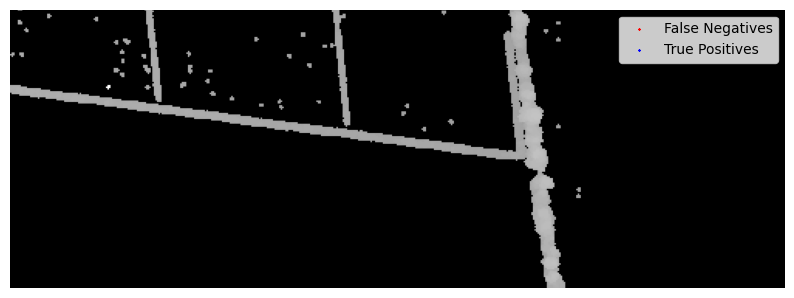

In [13]:
gg_x = x_values[right_classified_mask]-500
gg_y = y_values[right_classified_mask]-570

m1 = (gg_x >= 2) & (gg_x <= image.shape[1])
m2 = (gg_y >= 2) & (gg_y <= 180)

gg_x = gg_x[m1 & m2].astype(int)
gg_y = gg_y[m1 & m2].astype(int)


not_gg_x = x_values[miss_classified_mask]-500
not_gg_y = y_values[miss_classified_mask]-570

not_m1 = (not_gg_x >= 0) & (not_gg_x <= image.shape[1])
not_m2 = (not_gg_y >= 0) & (not_gg_y <= 180)

not_gg_x = not_gg_x[not_m1 & not_m2].astype(int)
not_gg_y = not_gg_y[not_m1 & not_m2].astype(int)

plt.figure(figsize=(10,10))
plt.imshow(image[570:750, 500:image.shape[1]], cmap='gray')
plt.scatter(not_gg_x, not_gg_y, color='r', s=1, marker='x', label='False Negatives')
plt.scatter(gg_x, gg_y, color='b', s=1, marker='x', label='True Positives')
plt.legend()
plt.axis('off')
plt.savefig('BadDataQuality.png', dpi = 300, bbox_inches = 'tight')

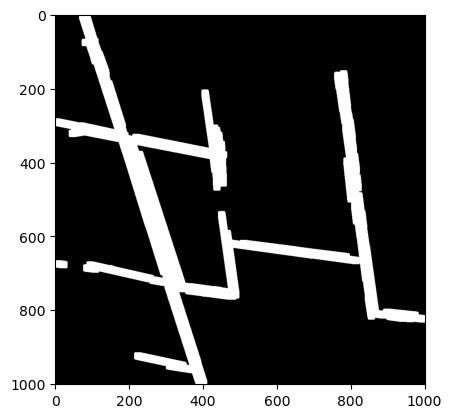

In [14]:
plt.figure()
plt.imshow(dilation_cirkular_kernel, cmap='gray')
plt.show()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [16]:
# Find contours in the binary image
contours, _ = cv2.findContours(dilation_cirkular_kernel, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [17]:

#x1 = cv2.pointPolygonTest(contours[0], (x, y), False)

In [32]:
coords = []
for i in range(1000):
    for j in range(1000):
        if cv2.pointPolygonTest(contours[0], (i,j), False) != -1:
            coords.append([i,j])
coords = np.array(coords)





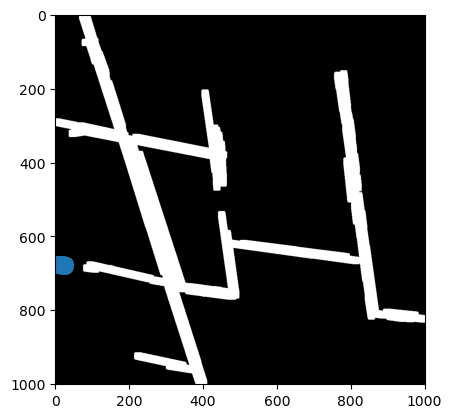

In [33]:
plt.figure()
plt.imshow(dilation_cirkular_kernel, cmap='gray')
plt.scatter(coords[:,0], coords[:,1])
plt.show()